In [341]:
import pandas as pd
import os
import bids
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from ghost.phantom import Caliber137
import numpy as np
import ants

In [2]:
uname = os.environ.get('USER')

if uname == 'emil':
    projdir = '/Users/emil/Projects/QA/CaliberPaper/lunarc/QA_paper/project'
elif uname == 'em2876lj':
    projdir = '/home/em2876lj/Projects/QA/QA_paper/project'

subses = pd.read_csv(os.path.join(projdir, 'code', 'slurm', 'all_sessions.txt'), delimiter=' ', names=['Subject', 'Session'])
layout = bids.BIDSLayout(root=projdir+'/rawdata', derivatives=projdir+'/derivatives')

In [346]:
f.filename

'sub-P0039_ses-20240207083415_rec-axi_run-02_T2w.nii.gz'

In [347]:
rows_to_add = []
my_df = pd.DataFrame(columns=['Subject', 'Session', 'Run', 'Orientation', 'filename'])

nnUnet_num = 1
for i,row in tqdm(subses.iterrows()):
    for orient in ['sag', 'cor', 'axi']:
        runs = [1,2] if orient == 'axi' else [None]

        for run in runs:
            try:
                f = layout.get(scope='raw', subject=row.Subject, 
                            session=row.Session, extension='.nii.gz', run=run, 
                            reconstruction=orient, suffix='T2w')[0]
                rows_to_add.append({'Subject':row.Subject, 'Session':row.Session, 'Run':run, 'Orientation':orient, 'Filename':f.filename})

            except IndexError:
                print("no file")
            
            nnUnet_num += 1

98it [00:02, 37.01it/s]

no file
no file


178it [00:04, 36.39it/s]

no file
no file
no file
no file


206it [00:05, 37.15it/s]

no file
no file


244it [00:06, 36.14it/s]


In [348]:
my_df = pd.DataFrame(rows_to_add)
my_df

,Subject,Session,Run,Orientation,Filename
0,P0003,20230927164642,NaN,sag,sub-P0003_ses-20230927164642_rec-sag_T2w.nii.gz
1,P0003,20230927164642,NaN,cor,sub-P0003_ses-20230927164642_rec-cor_T2w.nii.gz
2,P0003,20230927164642,1.0,axi,sub-P0003_ses-20230927164642_rec-axi_run-01_T2...
3,P0003,20230927164642,2.0,axi,sub-P0003_ses-20230927164642_rec-axi_run-02_T2...
4,P0003,20230928180538,NaN,sag,sub-P0003_ses-20230928180538_rec-sag_T2w.nii.gz
...,...,...,...,...,...
963,P0039,20240202093220,2.0,axi,sub-P0039_ses-20240202093220_rec-axi_run-02_T2...
964,P0039,20240207083415,NaN,sag,sub-P0039_ses-20240207083415_rec-sag_T2w.nii.gz
965,P0039,20240207083415,NaN,cor,sub-P0039_ses-20240207083415_rec-cor_T2w.nii.gz
966,P0039,20240207083415,1.0,axi,sub-P0039_ses-20240207083415_rec-axi_run-01_T2...


In [3]:
all_rows = []
for i,row in tqdm(subses.iterrows()):

    for orient in ['sag', 'cor', 'axi']:
        runs = [1,2] if orient == 'axi' else [None]

        for run in runs:
            try:
                f = layout.get(scope='derivatives', subject=row.Subject, 
                            session=row.Session, extension='.csv', run=run, 
                            reconstruction=orient, desc=f'FidPos')[0]
                
                df = pd.read_csv(f).drop(columns=['Unnamed: 0'])
                
                df['Axis'] = orient
                df['Run'] = run if orient == 'axi' else 1
                df['Subject'] = row.Subject
                df['Session'] = row.Session

                all_rows.append(df)

            except IndexError:
                continue

244it [00:37,  6.59it/s]


In [4]:
df = pd.concat(all_rows, ignore_index=True)

In [92]:
df['MagDiff'] = np.sqrt(df['diffX']**2 + df['diffY']**2 + df['diffZ']**2)

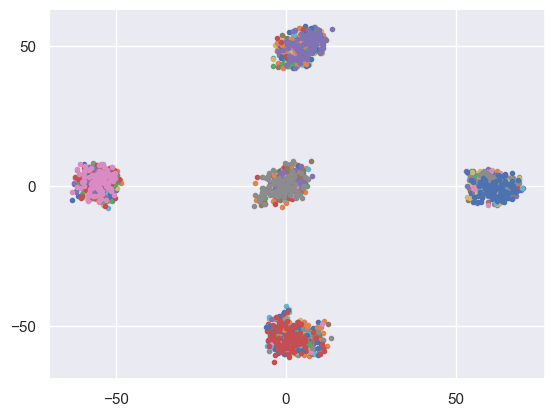

In [24]:
phantom = Caliber137()
ref_loc = phantom.get_ref_fiducial_locations()

fig = plt.figure()
k = 50

for i in range(6):
    data=df[(df['Axis']=='axi') & (df['label']==i)]

    for sub in data.Subject.unique():
        data1 = data[data['Subject']==sub]
        x = data1.diffX * k + ref_loc[0,i]
        y = data1.diffY * k + ref_loc[1,i]
        plt.plot(x,y,'.')
    
    plt.xticks([-50,0,50])
    plt.yticks([-50,0,50])


In [26]:
midf = pd.MultiIndex.from_frame(df)

In [48]:
# Access data for label 5, subject 'P0039', axis 'axi', and run 1

data

,X,Y,Z,refX,refY,refZ,diffX,diffY,diffZ
Subject,,,,,,,,,
P0003,0.092540,-0.032201,49.856589,0.0,0.0,50.0,0.092540,-0.032201,-0.143411
P0004,0.106934,-0.005498,49.959298,0.0,0.0,50.0,0.106934,-0.005498,-0.040702
P0007,0.085187,0.051114,49.857533,0.0,0.0,50.0,0.085187,0.051114,-0.142467
P0008,0.103081,-0.010889,49.961050,0.0,0.0,50.0,0.103081,-0.010889,-0.038950
P0009,0.097623,-0.025323,49.882274,0.0,0.0,50.0,0.097623,-0.025323,-0.117726
P0010,0.121789,-0.011389,49.950251,0.0,0.0,50.0,0.121789,-0.011389,-0.049749
P0012,0.094345,-0.027487,49.963084,0.0,0.0,50.0,0.094345,-0.027487,-0.036916
P0013,0.037054,-0.012421,49.867280,0.0,0.0,50.0,0.037054,-0.012421,-0.132720
P0014,0.105638,0.005295,49.904710,0.0,0.0,50.0,0.105638,0.005295,-0.095290


Text(0.5, 1.0, 'P11-P15')

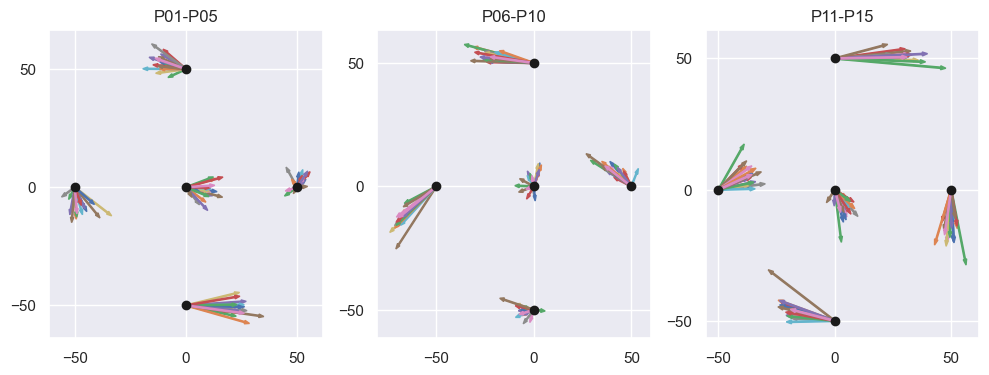

In [93]:
dfg = df.groupby(['label','Axis', 'Run','Subject']).mean(numeric_only=True)

fig, axes = plt.subplots(1,3,figsize=(12,4))
r = 100
ref_loc = phantom.get_ref_fiducial_locations()

for p in range(1,16):
    ax = axes[(p-1)//5]
    data = dfg.loc[(p, 'axi', 1)]
    k = 0
    ax.plot(ref_loc[0,p-1], ref_loc[1,p-1], 'ok')
    for i,row in data.iterrows():
        ax.arrow(row.refX, row.refY, row.diffX*r, row.diffY*r, color=f'C{k:02d}', width=0.5)
        k+=1
    
for ax in axes.flatten():
    ax.set_xticks([-50,0,50])
    ax.set_yticks([-50,0,50])

axes[0].set_title('P01-P05')
axes[1].set_title('P06-P10')
axes[2].set_title('P11-P15')

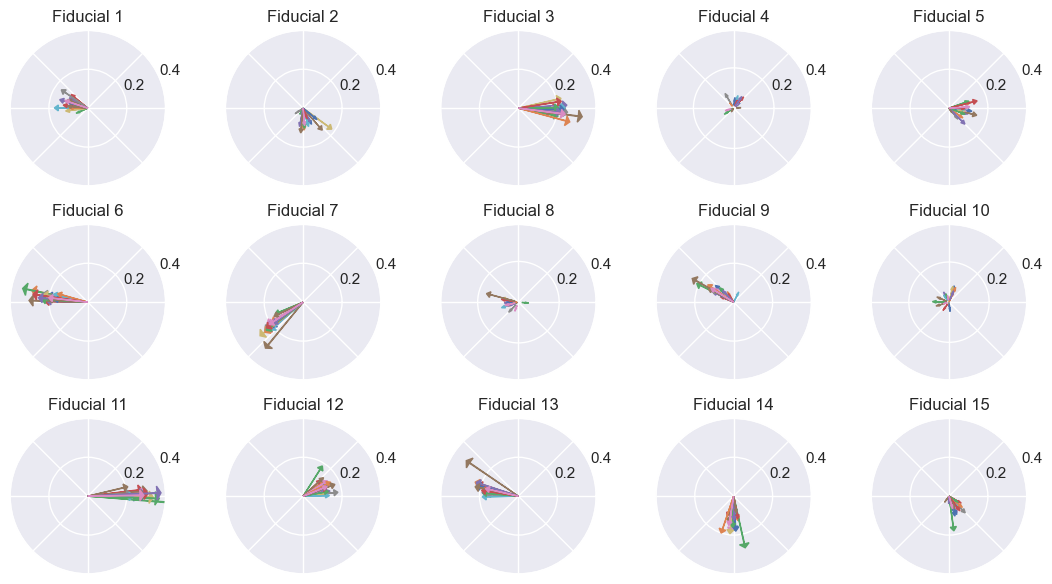

In [155]:
dfg = df.groupby(['label','Axis', 'Run','Subject']).mean(numeric_only=True)
fig, axes = plt.subplots(3,5,figsize=(11,6), subplot_kw={'projection':'polar'})

for p in range(1,16):
    ax = axes[np.unravel_index(p-1,[3,5])]
    data = dfg.loc[(p, 'axi', 1)]
    
    k = 0
    for i,row in data.iterrows():
        r = np.sqrt(row.diffX**2 + row.diffY**2)
        theta = np.arctan2(row.diffY,row.diffX)
        ax.arrow(theta, 0, 0, r, width=0.01, head_width=0.2, head_length=0.02, color=f'C{k:02d}', length_includes_head=True)
        k+=1
    ax.grid('off')
    ax.axis([None,None,None,0.4])
    ax.set_title(f'Fiducial {p}')

for ax in axes.flatten():
    ax.set_xticklabels([])
    ax.set_rticks([0.2, 0.4])

plt.tight_layout()
plt.show()

In [96]:
dfg = df.groupby(['Axis', 'Run','Subject']).mean(numeric_only=True)


In [116]:
dfg

label         X         Y         Z  refX  refY  refZ  \
Axis Run Subject                                                          
axi  1   P0003      8.0  0.005071 -0.015278 -0.005647   0.0   0.0   0.0   
         P0004      8.0 -0.000667  0.001014 -0.016305   0.0   0.0   0.0   
         P0007      8.0 -0.003845 -0.017986 -0.015570   0.0   0.0   0.0   
         P0008      8.0 -0.000954  0.004631  0.017711   0.0   0.0   0.0   
         P0009      8.0 -0.000005 -0.013087  0.008057   0.0   0.0   0.0   
...                 ...       ...       ...       ...   ...   ...   ...   
sag  1   P0027      8.0  0.035821  0.035042 -0.000980   0.0   0.0   0.0   
         P0029      8.0  0.029699  0.021694  0.000222   0.0   0.0   0.0   
         P0030      8.0 -0.022811 -0.005333 -0.004431   0.0   0.0   0.0   
         P0031      8.0  0.022141  0.048008  0.003740   0.0   0.0   0.0   
         P0039      8.0  0.021716  0.033541  0.000102   0.0   0.0   0.0   

                     diffX     diffY     diffZ   MagDiff  
Axis Run Subject                                          
axi  1   P0003    0.005071 -0.015278 -0.005647  0.225898  
         P0004   -0.000667  0.001014 -0.016305  0.225781  
         P0007   -0.003845 -0.017986 -0.015570  0.246919  
         P0008   -0.000954  0.004631  0.017711  0.223656  
         P0009   -0.000005 -0.013087  0.008057  0.223217  
...                    ...       ...       ...       ...  
sag  1   P0027    0.035821  0.035042 -0.000980  0.283022  
         P0029    0.029699  0.021694  0.000222  0.252086  
         P0030   -0.022811 -0.005333 -0.004431  0.245254  
         P0031    0.022141  0.048008  0.003740  0.304993  
         P0039    0.021716  0.033541  0.000102  0.289146  

[68 rows x 11 columns]

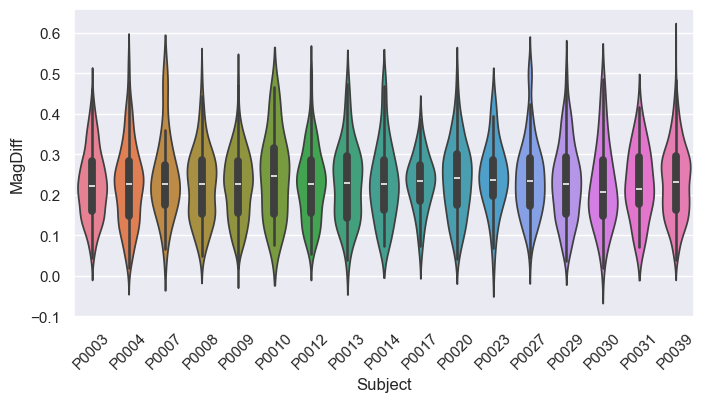

In [110]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
sns.violinplot(data=df[(df['Axis']=='axi') & (df['Run']==1)], y='MagDiff', x='Subject', ax=ax, hue='Subject')

ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=45)
plt.show()

<Axes: xlabel='label', ylabel='MagDiff'>

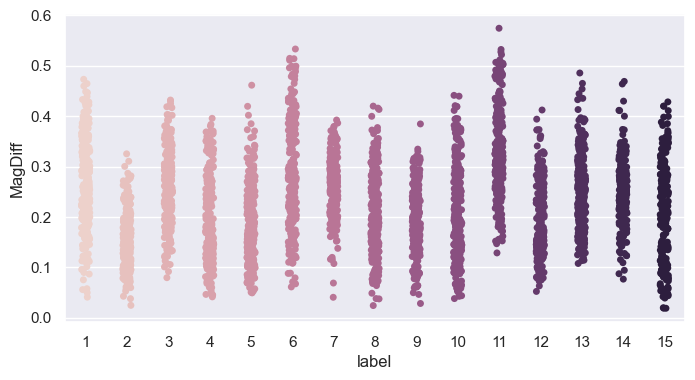

In [158]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
sns.stripplot(data=df[(df['Axis']=='axi') & (df['Run']==1)], y='MagDiff', x='label', ax=ax, hue='label', legend=False)

In [193]:
# Reproducibility of distortions on axial scans
df_axial = df[df['Axis']=='axi'].drop(columns=['Axis']).reset_index()
df_axial.sort_values(by=['Run', 'Subject', 'Session', 'label'], inplace=True)

for ax in ['X', 'Y', 'Z']:
    df_axial[f'dd{ax}'] = df_axial.groupby(['Subject', 'Session', 'label'])[f'diff{ax}'].diff()

df_axial['Magdd'] = np.sqrt(df_axial['ddX']**2 + df_axial['ddY']**2 + df_axial['ddZ']**2)

In [203]:
df_axial['label'] = df_axial['label'].astype(str)

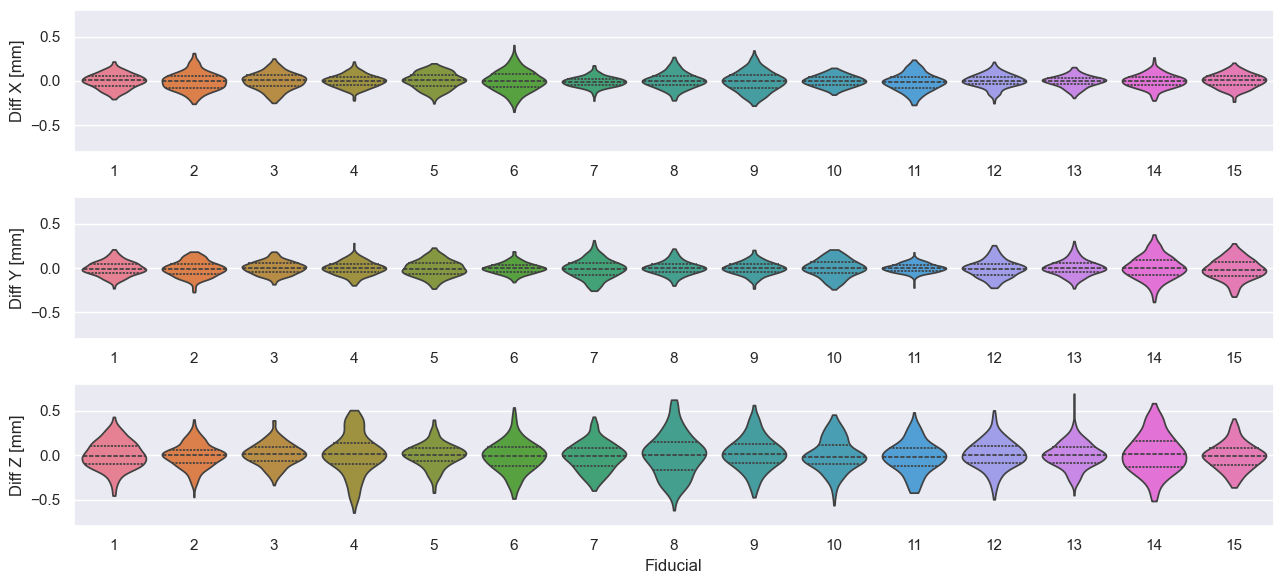

In [213]:
fig, axes = plt.subplots(3,1,figsize=(13,6))
axl = ['X', 'Y', 'Z']
for i in range(3):
    sns.violinplot(data=df_axial[df_axial['Run']==2], x='label', y=f'dd{axl[i]}', ax=axes[i], hue='label', 
                   legend=None, cut=0, inner='quart')
    axes[i].set_ylim([-.8, .8])
    axes[i].set_ylabel(f'Diff {axl[i]} [mm]')
    if i==2:
        axes[i].set_xlabel('Fiducial')
    else:
        axes[i].set_xlabel(None)

plt.tight_layout()
plt.show()

In [270]:
df_scale = pd.DataFrame()

for sub in tqdm(df.Subject.unique()):

    for ses in df[df['Subject']==sub].Session.unique():

        for orient in ['sag', 'cor', 'axi']:
            runs = [1,2] if orient == 'axi' else [None]

            for run in runs:
                try:
                    fname = layout.get(scope='derivatives', 
                            suffix='T2w', 
                            run=run, 
                            subject=sub, 
                            reconstruction=orient, 
                            session=ses, 
                            desc=f'Fiducials0GenericAffine')[0]
                except IndexError:
                    print(f'No xfm for {sub} {ses} run={run} {orient}')

                xfm = ants.read_transform(fname).invert()
                sX = xfm.parameters[0]
                sY = xfm.parameters[4]
                sZ = xfm.parameters[8]
                S = abs(np.linalg.det(xfm.parameters.reshape([4,3])[0:3,:]))
                D = {'Subject':[sub], 'Session':[ses], 'Axis':[orient], 'Run':[run], 'sX':[sX], 'sY':[sY], 'sZ':[sZ], 'S':[S]}
                df_scale = pd.concat((df_scale, pd.DataFrame.from_dict(D)))

 35%|███▌      | 6/17 [00:20<00:35,  3.21s/it]

No xfm for P0012 20230915095751 run=None sag
No xfm for P0012 20230915095751 run=None cor


 94%|█████████▍| 16/17 [00:42<00:02,  2.11s/it]

No xfm for P0039 20231106081553 run=None sag
No xfm for P0039 20231106081553 run=None cor


100%|██████████| 17/17 [00:53<00:00,  3.14s/it]


In [269]:
xfm.invert()

ANTsTransform
	 Type       : AffineTransform
	 Dimension  : 3
	 Precision  : float

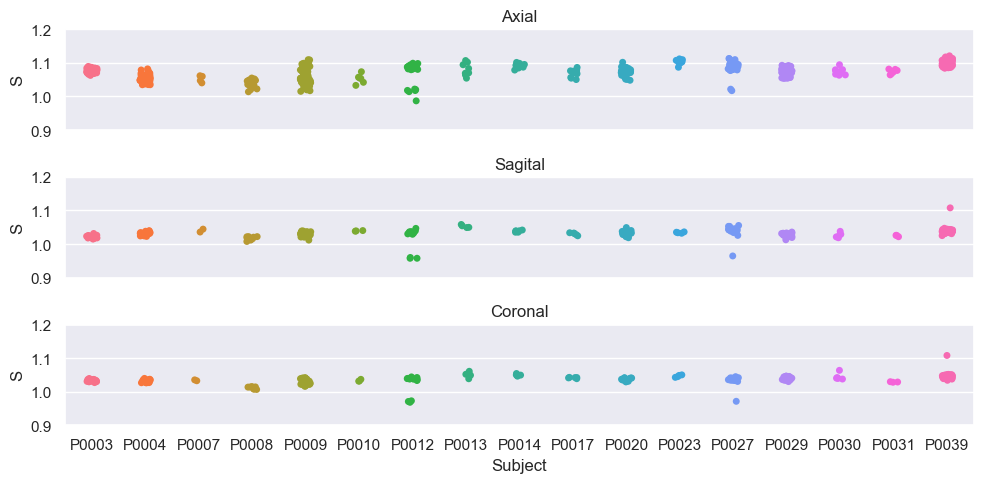

In [274]:
fig, axes = plt.subplots(3,1,figsize=(10,5))

sns.stripplot(data=df_scale[df_scale['Axis']=='axi'], x='Subject', y='S', ax=axes[0], hue='Subject')
sns.stripplot(data=df_scale[df_scale['Axis']=='sag'], x='Subject', y='S', ax=axes[1], hue='Subject')
sns.stripplot(data=df_scale[df_scale['Axis']=='cor'], x='Subject', y='S', ax=axes[2], hue='Subject')

axes[0].set_xlabel(None)
axes[0].set_xticklabels([])
axes[0].set_title('Axial')
axes[1].set_xlabel(None)
axes[1].set_xticklabels([])
axes[1].set_title('Sagital')
axes[2].set_title('Coronal')

for ax in axes:
    ax.set_ylim([0.9, 1.2])

plt.tight_layout()

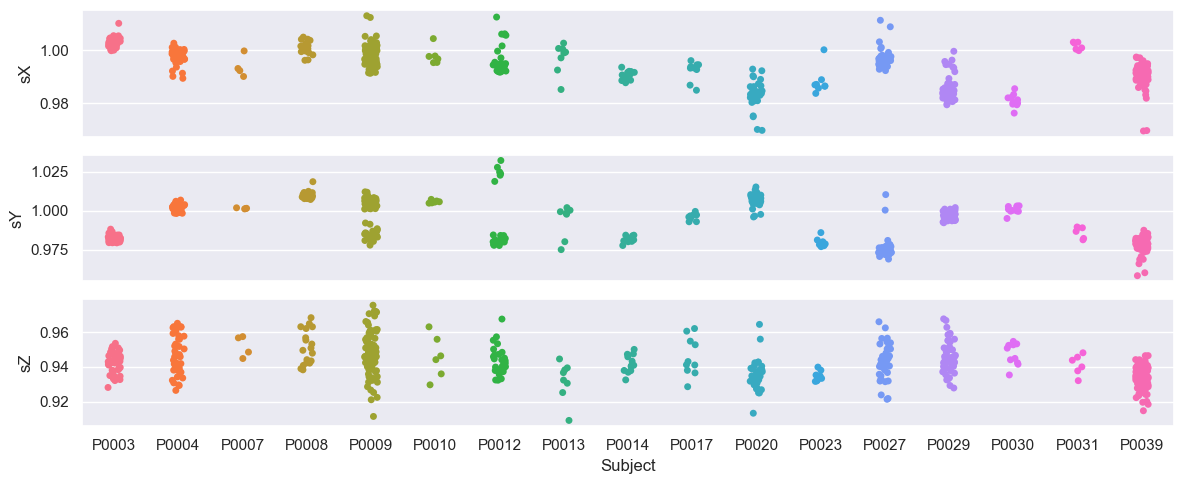

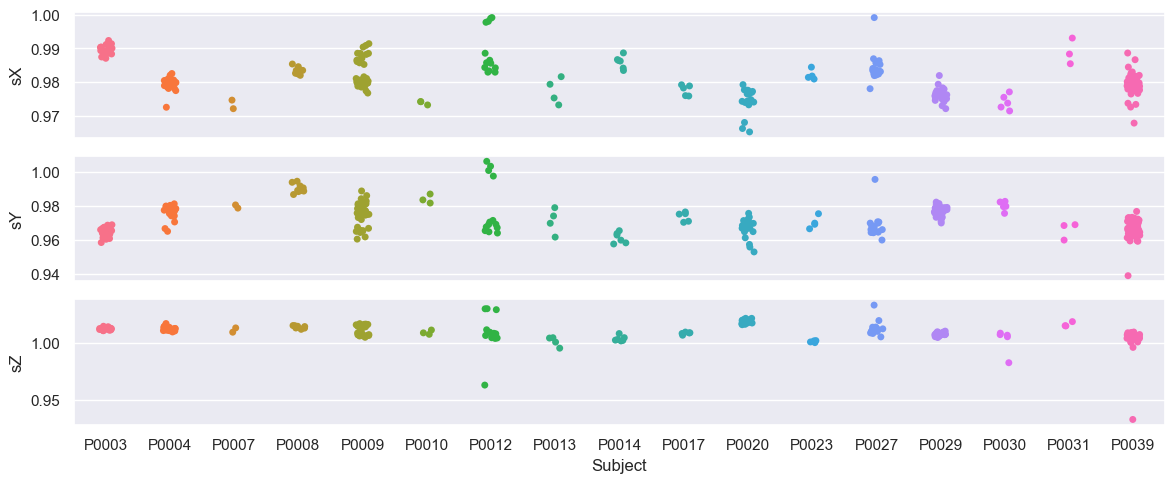

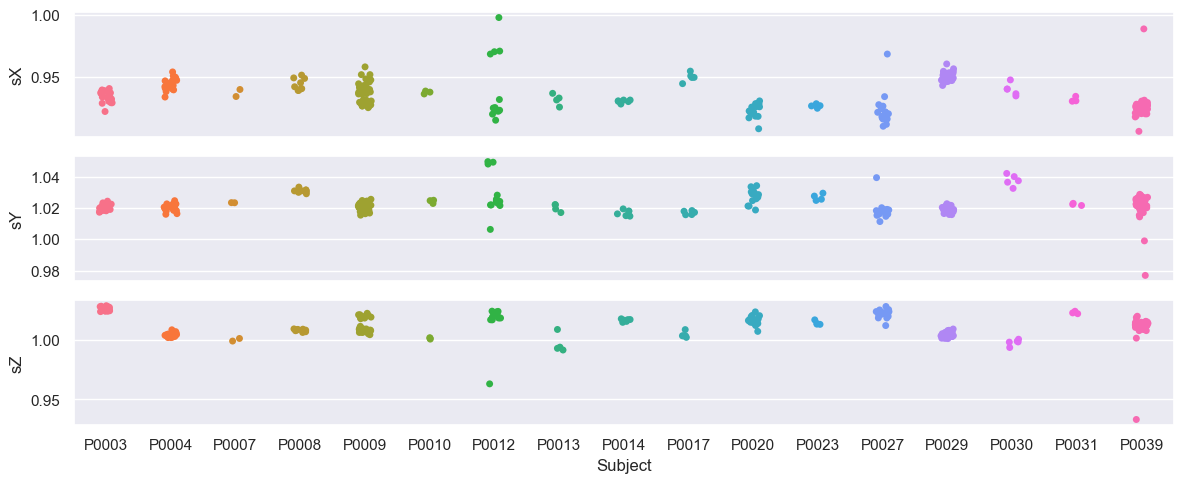

In [247]:
# Look at scale factors
def make_plot_scales(df, axis):
    fig, axes = plt.subplots(3,1,figsize=(12,5))

    sns.stripplot(data=df[df['Axis']==axis], x='Subject', y='sX', ax=axes[0], hue='Subject')
    sns.stripplot(data=df[df['Axis']==axis], x='Subject', y='sY', ax=axes[1], hue='Subject')
    sns.stripplot(data=df[df['Axis']==axis], x='Subject', y='sZ', ax=axes[2], hue='Subject')

    axes[0].set_xlabel(None)
    axes[0].set_xticklabels([])
    axes[1].set_xlabel(None)
    axes[1].set_xticklabels([])
    
    plt.tight_layout()


make_plot_scales(df_scale, 'axi')
plt.show()

make_plot_scales(df_scale, 'cor')
plt.show()

make_plot_scales(df_scale, 'sag')
plt.show()

In [314]:
# Get coordinates of fiducials
fname = '/Users/emil/Projects/QA/CaliberPaper/lunarc/QA_paper/project/derivatives/sub-P0003/ses-20230927164642/ghost/sub-P0003_ses-20230927164642_rec-axi_run-01_desc-segRegFidLabels_T2w.nii.gz'

In [319]:
seg = ants.image_read(fname)

# Label stats
seg_df = ants.label_stats(image=seg, label_image=seg)
seg_df = seg_df[seg_df.LabelValue > 0]
seg_df.drop(columns=['Mean', 'Min', 'Max', 'Variance', 'Count', 'Volume', 'Mass', 't'], inplace=True)
seg_df.reset_index(inplace=True, drop=True)

# Get positions
seg_pos = np.array([seg_df.x, seg_df.y, seg_df.z]).T
ref_loc = phantom.get_ref_fiducial_locations().T

# Affine registration with points
reg = ants.fit_transform_to_paired_points(seg_pos, ref_loc, transform_type='affine')
new_points = np.zeros_like(ref_loc)
for i in range(ref_loc.shape[0]):
    new_points[i,:] = ants.apply_ants_transform_to_point(reg.invert(), seg_pos[i,:])

# Create new dataframe with the results
seg_df.rename(columns={'x':'x_org','y':'y_org','z':'z_org'}, inplace=True)
seg_df['x_ref'] = ref_loc[:,0]
seg_df['y_ref'] = ref_loc[:,1]
seg_df['z_ref'] = ref_loc[:,2]

seg_df['x_reg'] = new_points[:,0]
seg_df['y_reg'] = new_points[:,1]
seg_df['z_reg'] = new_points[:,2]

seg_df['x_diff'] = seg_df['x_ref'] - seg_df['x_reg']
seg_df['y_diff'] = seg_df['y_ref'] - seg_df['y_reg']
seg_df['z_diff'] = seg_df['z_ref'] - seg_df['z_reg']

In [335]:
mat = reg.parameters.reshape([3,4])

In [336]:
mat

array([[-1.00306964e+00, -1.16272867e-02,  1.01579651e-02,
         1.21106524e-02],
       [-1.03682923e+00,  1.74253453e-02, -2.19267998e-02,
         2.80012880e-02],
       [ 9.69211578e-01,  8.81248627e+01,  1.02589348e+02,
        -9.51791840e+01]])

In [339]:
np.savetxt('test.txt', mat)

In [340]:
np.loadtxt('test.txt')

array([[-1.00306964e+00, -1.16272867e-02,  1.01579651e-02,
         1.21106524e-02],
       [-1.03682923e+00,  1.74253453e-02, -2.19267998e-02,
         2.80012880e-02],
       [ 9.69211578e-01,  8.81248627e+01,  1.02589348e+02,
        -9.51791840e+01]])